In [5]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path  
from src.models.baseline_models import prepare_data_for_forecast, train_baseline_models

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
# Load processed data from previous notebook
sales_long = pd.read_pickle('../data/processed/sales_long.pkl') if Path('../data/processed/sales_long.pkl').exists() else None

if sales_long is None:
    print("❌ Sales data not found. Run notebook 01_eda.ipynb first and save the data.")
else:
    print(f"✅ Loaded {len(sales_long):,} rows")
    print(f"Date range: {sales_long['date'].min()} to {sales_long['date'].max()}")

✅ Loaded 58,327,370 rows
Date range: 2011-01-29 00:00:00 to 2016-04-24 00:00:00


In [7]:
# Prepare data for StatsForecast (use small sample for testing)
print("Preparing data for forecasting...")
forecast_data = prepare_data_for_forecast(sales_long, n_series=100)

print(f"Selected {forecast_data['unique_id'].nunique()} series")
print(forecast_data.head())


Preparing data for forecasting...
Selected 100 series
                            unique_id         ds  y
0       HOBBIES_1_001_CA_1_validation 2011-01-29  0
30490   HOBBIES_1_001_CA_1_validation 2011-01-30  0
60980   HOBBIES_1_001_CA_1_validation 2011-01-31  0
91470   HOBBIES_1_001_CA_1_validation 2011-02-01  0
121960  HOBBIES_1_001_CA_1_validation 2011-02-02  0


In [8]:
# Train baseline models
horizon = 28  # Forecast next 28 days

print("Training models (this may take a few minutes)...")
forecasts, sf_model = train_baseline_models(forecast_data, horizon=horizon)

print("\n✅ Training completed!")
print(f"\nForecasts shape: {forecasts.shape}")
print(f"Columns: {forecasts.columns.tolist()}")
print("\nSample forecasts:")
print(forecasts.head(10))

Training models (this may take a few minutes)...
Training 4 models on 100 series...


Forecast:  90%|█████████ | 9/10 [01:39<00:09,  9.16s/it]


✅ Training completed!

Forecasts shape: (2800, 5)
Columns: ['ds', 'Naive', 'SeasonalNaive', 'CrostonClassic', 'AutoARIMA']

Sample forecasts:
                                      ds  Naive  SeasonalNaive  \
unique_id                                                        
HOBBIES_1_001_CA_1_validation 2016-04-25    1.0            1.0   
HOBBIES_1_001_CA_1_validation 2016-04-26    1.0            1.0   
HOBBIES_1_001_CA_1_validation 2016-04-27    1.0            1.0   
HOBBIES_1_001_CA_1_validation 2016-04-28    1.0            3.0   
HOBBIES_1_001_CA_1_validation 2016-04-29    1.0            0.0   
HOBBIES_1_001_CA_1_validation 2016-04-30    1.0            1.0   
HOBBIES_1_001_CA_1_validation 2016-05-01    1.0            1.0   
HOBBIES_1_001_CA_1_validation 2016-05-02    1.0            1.0   
HOBBIES_1_001_CA_1_validation 2016-05-03    1.0            1.0   
HOBBIES_1_001_CA_1_validation 2016-05-04    1.0            1.0   

                               CrostonClassic  AutoARIMA  
uniqu

Forecast: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


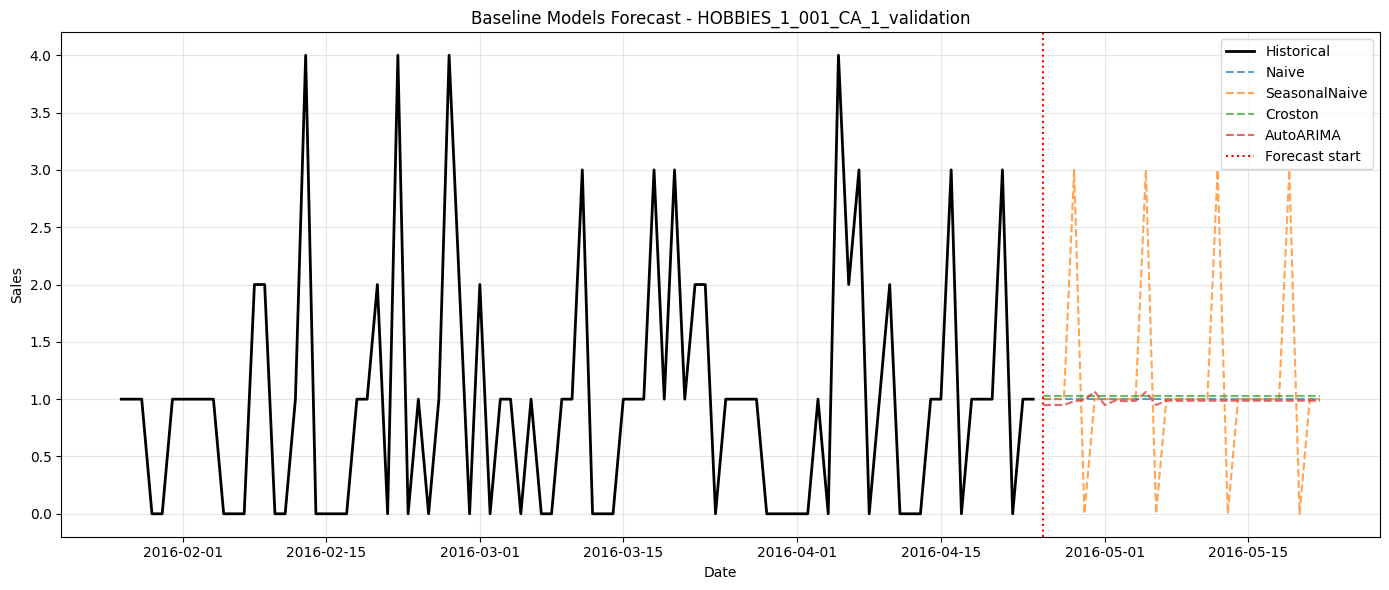

In [9]:
# Visualize forecasts for one series
sample_id = forecast_data['unique_id'].iloc[0]

# Get historical data
historical = forecast_data[forecast_data['unique_id'] == sample_id].tail(90)  # Last 90 days
forecast_sample = forecasts.loc[sample_id]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data
ax.plot(historical['ds'], historical['y'], label='Historical', linewidth=2, color='black')

# Forecasts
ax.plot(forecast_sample['ds'], forecast_sample['Naive'], label='Naive', linestyle='--', alpha=0.7)
ax.plot(forecast_sample['ds'], forecast_sample['SeasonalNaive'], label='SeasonalNaive', linestyle='--', alpha=0.7)
ax.plot(forecast_sample['ds'], forecast_sample['CrostonClassic'], label='Croston', linestyle='--', alpha=0.7)
ax.plot(forecast_sample['ds'], forecast_sample['AutoARIMA'], label='AutoARIMA', linestyle='--', alpha=0.7)

ax.axvline(forecast_sample['ds'].iloc[0], color='red', linestyle=':', label='Forecast start')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title(f'Baseline Models Forecast - {sample_id}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# Split data into train and test
last_date = forecast_data['ds'].max()
train_end = last_date - pd.Timedelta(days=horizon)

train_data = forecast_data[forecast_data['ds'] <= train_end].copy()
test_data = forecast_data[forecast_data['ds'] > train_end].copy()

print(f"Train end: {train_end}")
print(f"Test start: {train_end + pd.Timedelta(days=1)}")
print(f"Test end: {last_date}")
print(f"\nTrain: {len(train_data)} rows")
print(f"Test: {len(test_data)} rows (should be {100 * 28} = 2800)")

# Retrain models on train data only
print("\nRetraining models on train data...")
forecasts_new, sf_model = train_baseline_models(train_data, horizon=horizon)

print("✅ Done!")


Train end: 2016-03-27 00:00:00
Test start: 2016-03-28 00:00:00
Test end: 2016-04-24 00:00:00

Train: 188500 rows
Test: 2800 rows (should be 2800 = 2800)

Retraining models on train data...
Training 4 models on 100 series...


Forecast:  90%|█████████ | 9/10 [01:58<00:12, 12.06s/it]

✅ Done!


Forecast: 100%|██████████| 10/10 [02:04<00:00, 12.49s/it]


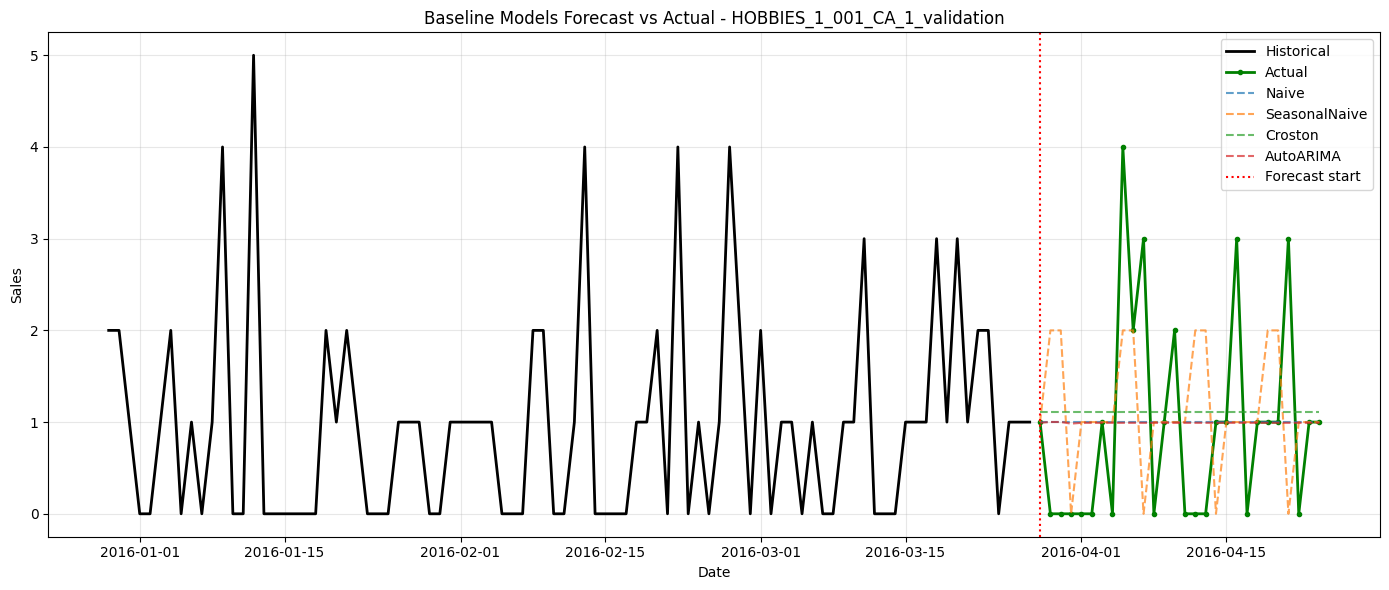


Actual sales in forecast period: 27
Naive forecast total: 28.00
SeasonalNaive forecast total: 32.00
Croston forecast total: 30.97
AutoARIMA forecast total: 27.78


In [11]:
# Visualize forecasts vs actual for one series
sample_id = train_data['unique_id'].iloc[0]

# Get data
historical = train_data[train_data['unique_id'] == sample_id].tail(90)
actual = test_data[test_data['unique_id'] == sample_id]
forecast_sample = forecasts_new.loc[sample_id]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data
ax.plot(historical['ds'], historical['y'], label='Historical', linewidth=2, color='black')

# Actual test data
ax.plot(actual['ds'], actual['y'], label='Actual', linewidth=2, color='green', marker='o', markersize=3)

# Forecasts
ax.plot(forecast_sample['ds'], forecast_sample['Naive'], label='Naive', linestyle='--', alpha=0.7)
ax.plot(forecast_sample['ds'], forecast_sample['SeasonalNaive'], label='SeasonalNaive', linestyle='--', alpha=0.7)
ax.plot(forecast_sample['ds'], forecast_sample['CrostonClassic'], label='Croston', linestyle='--', alpha=0.7)
ax.plot(forecast_sample['ds'], forecast_sample['AutoARIMA'], label='AutoARIMA', linestyle='--', alpha=0.7)

ax.axvline(forecast_sample['ds'].iloc[0], color='red', linestyle=':', label='Forecast start')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title(f'Baseline Models Forecast vs Actual - {sample_id}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nActual sales in forecast period: {actual['y'].sum()}")
print(f"Naive forecast total: {forecast_sample['Naive'].sum():.2f}")
print(f"SeasonalNaive forecast total: {forecast_sample['SeasonalNaive'].sum():.2f}")
print(f"Croston forecast total: {forecast_sample['CrostonClassic'].sum():.2f}")
print(f"AutoARIMA forecast total: {forecast_sample['AutoARIMA'].sum():.2f}")


In [12]:
# Calculate errors (MAE, RMSE) for all models
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Merge forecasts with actual test data
test_with_forecasts = test_data.merge(
    forecasts_new.reset_index(), 
    left_on=['unique_id', 'ds'], 
    right_on=['unique_id', 'ds']
)

# Calculate metrics for each model
models = ['Naive', 'SeasonalNaive', 'CrostonClassic', 'AutoARIMA']
results = {}

for model in models:
    mae = mean_absolute_error(test_with_forecasts['y'], test_with_forecasts[model])
    rmse = np.sqrt(mean_squared_error(test_with_forecasts['y'], test_with_forecasts[model]))
    results[model] = {'MAE': mae, 'RMSE': rmse}

# Display results
results_df = pd.DataFrame(results).T
print("Baseline Models Performance:\n")
print(results_df.round(3))


Baseline Models Performance:

                  MAE   RMSE
Naive           1.330  3.499
SeasonalNaive   1.403  3.556
CrostonClassic  1.130  2.607
AutoARIMA       1.113  2.606

(Lower is better)


In [13]:
# Save results
results_df.to_csv('../data/processed/baseline_results.csv')
forecasts_new.to_csv('../data/processed/baseline_forecasts.csv')

print("✅ Results saved!")
print(f"\nBaseline benchmark to beat:")
print(f"MAE: {results_df['MAE'].min():.3f}")
print(f"RMSE: {results_df['RMSE'].min():.3f}")

✅ Results saved!

Baseline benchmark to beat:
MAE: 1.113
RMSE: 2.606
